In [1]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fbprophet import Prophet
import plotly
from fbprophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
import numpy as np
import altair as alt

In [2]:
#change this to be whatever subreddit you want to analyze
subreddit = 'Depression_Help'

In [3]:
df = pd.read_csv(f'{subreddit}_data/raw_data_2017/01Jan2017.csv').drop(['Unnamed: 0'], axis = 1)
for year in range(2017,2021):
    #TODO: Change when changing subreddit
    for file in os.listdir(f'{subreddit}_data/raw_data_{year}'):
        if file[-3:] == 'csv':
            #TODO: Change when changing subreddit
            df_new = pd.read_csv(f'{subreddit}_data/raw_data_{year}/{file}').drop(['Unnamed: 0'], axis=1)
            df_new.time = df_new.time.apply(lambda x: file[:-4])
            df = pd.concat([df, df_new]).reset_index(drop=True)
df.head()


,text,time,score
0,I don't even know where to begin. I've never ...,01Jan2017,7
1,Earlier this year I lost a pillar in my life t...,01Jan2017,2
2,I am so filled with anger and rage I can't kee...,01Jan2017,3
3,"I drink, to excess, then I get sad. Really sad...",01Jan2017,2
4,My closest childhood friend has had a rough se...,01Jan2017,3


In [4]:
df.time = df.time.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
df = df.sort_values('time')

In [5]:
dates = sorted([datetime.strftime(datetime.strptime(file[:-4], '%d%b%Y'), '%Y-%m-%d') \
                for year in range(2017, 2021) \
                for file in os.listdir(f'{subreddit}_data/raw_data_{year}') \
                if file[-3:] == 'csv'])
data = []
df_text = df[df['text'] != '[deleted]']

for date in dates:
    data.append(df_text[df_text['time'] == datetime.strptime(date, '%Y-%m-%d')])

In [6]:
#prophet expects a dataframe with (date, value)
prophet_input = pd.DataFrame(columns = ['ds','y'])
analyzer = SentimentIntensityAnalyzer()
for i in tqdm(range(0, len(data))):
    texts = data[i]['text'].values
    if (len(texts) == 0): 
        continue
    date = data[i]['time'].iloc[0] #date will be the same for all values in list, just pick first
    #iterate over the posts in the texts list
    for j in texts:
        try:
            vs = analyzer.polarity_scores(j)
            new_data = pd.DataFrame([[date, vs['compound']]], columns = ['ds','y'])
            prophet_input = pd.concat([prophet_input, new_data], ignore_index = True)
        except:
            print("We couldn't process this post because it was: ", j)
            continue


100%|██████████| 692/692 [04:05<00:00,  2.82it/s]


In [7]:
#need to split dataframe that was created above into four chunks (based on year) and then groupby date
data_2017 = prophet_input[prophet_input['ds'].dt.year == 2017] 
data_2018 = prophet_input[prophet_input['ds'].dt.year == 2018] 
data_2019 = prophet_input[prophet_input['ds'].dt.year == 2019] 
data_2020 = prophet_input[prophet_input['ds'].dt.year == 2020] 
grouped_2017 = data_2017.groupby([data_2017['ds'].dt.date]).mean()
grouped_2018 = data_2018.groupby([data_2018['ds'].dt.date]).mean()
grouped_2019 = data_2019.groupby([data_2019['ds'].dt.date]).mean()
grouped_2020 = data_2020.groupby([data_2020['ds'].dt.date]).mean()
df_2017 = grouped_2017.reset_index()
df_2018 = grouped_2018.reset_index()
df_2019 = grouped_2019.reset_index()
df_2020 = grouped_2020.reset_index()
df_all_years = pd.concat([df_2017,df_2018,df_2019,df_2020])
df_all_years.set_index('ds', inplace = True)

In [8]:
freq = df_all_years.reset_index().rename(columns ={'ds': 'date', 'y':'Average Vader Score'})
#get rolling average of all data and plot it overtime
smoothed_vader_score = df_all_years.rolling(30).mean().reset_index().rename(columns ={'ds': 'date', 'y':'Average Vader Score'})
#convert to datetime because altair was being weird
freq["date"] = pd.to_datetime(freq["date"])
smoothed_vader_score["date"] = pd.to_datetime(smoothed_vader_score["date"])
series = alt.Chart(freq).mark_line(opacity=0.3,
                                  ).encode(x='date', y='Average Vader Score'
                                  ).properties(title=f'VADER compound score of post on r/{subreddit}' 
                                  ).interactive(bind_y=False)

smoothed = alt.Chart(smoothed_vader_score.reset_index()).mark_line(
                                                           ).encode(x='date', y='Average Vader Score'
                                                           ).properties(title=f'Vader score of r/{subreddit} Posts' 
                                                           ).interactive(bind_y=False)

chart = (series + smoothed).properties(width=800, height=300)
chart.save(f'figures/{subreddit}/VADER_Score.html')


ds
2017-01-01   -0.412406
2017-01-03    0.406394
2017-01-05    0.491135
2017-01-07    0.606189
2017-01-09    0.411971
                ...   
2020-12-22    0.503179
2020-12-24    0.859734
2020-12-26    0.611158
2020-12-28    0.748556
2020-12-30    0.407316
Name: y, Length: 690, dtype: float64


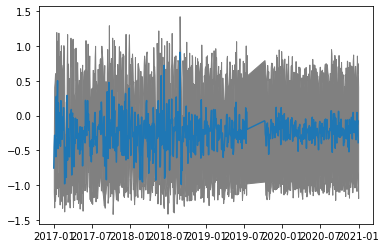

In [9]:
# prophet_input['ds'] = prophet_input['ds'].apply(lambda x: x.replace(day = 1))
mean_df = prophet_input.groupby(prophet_input['ds'].dt.date).mean().rolling(30)
std_df = prophet_input.groupby(prophet_input['ds'].dt.date).std().rolling(30)

plt.plot(mean_df['y'],'-')
print(mean_df['y']+std_df['y'])

plt.fill_between(mean_df.index, mean_df['y']+std_df['y'], mean_df['y']-std_df['y'], color='gray')

In [18]:
df_all = pd.concat([data_2017,data_2018,data_2019,data_2020])
df_low_VADER = df_all[df_all['y'] < -0.05]
posts_per_day_low_VADER = df_low_VADER.groupby([df_low_VADER['ds'].dt.date]).count().drop(columns=['ds'])
posts_per_day = df_all.groupby([df_all['ds'].dt.date]).count().drop(columns=['ds'])

normalized_VADER_count = (posts_per_day_low_VADER/posts_per_day)
smoothed_VADER = normalized_VADER_count.rolling(7).mean().reset_index()
print(smoothed_VADER)
smoothed_VADER['ds'] = pd.to_datetime(smoothed_VADER['ds'])

VADER_Norm_Posts = alt.Chart(smoothed_VADER).interactive(bind_y=False).mark_line(opacity=0.3).encode(x='ds',y='y').properties(title=f'Frequency of posts with compound score less than -0.05 on r/{subreddit} normalized by number of posts (on that day)')
chart = (VADER_Norm_Posts).properties(width=800, height=300)
chart.save(f'figures/{subreddit}/Frequency_of_low_VADER_norm_posts.html')

             ds         y
0    2017-01-01       NaN
1    2017-01-03       NaN
2    2017-01-05       NaN
3    2017-01-07       NaN
4    2017-01-09       NaN
..          ...       ...
685  2020-12-22  0.590084
686  2020-12-24  0.570243
687  2020-12-26  0.564071
688  2020-12-28  0.568837
689  2020-12-30  0.593827

[690 rows x 2 columns]


In [ ]:
trend = pd.read_csv(f'{subreddit}_data/subscriber_count.csv')
trend['subscribers'] = trend['subscribers'].interpolate()
trend['date'] = trend['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').replace(hour=0, minute=0))
overlap = pd.DataFrame()
dates = freq[freq['date'].isin(trend.date)]['date']
overlap['date'] = dates
overlap_subs = trend[trend['date'].isin(dates)].reset_index().drop(['index'], axis=1)
overlap_subs_new = overlap_subs.set_index('date')
normalized_VADER_subscribers = (posts_per_day_low_VADER['y']/overlap_subs_new['subscribers'])
df_subs = pd.DataFrame({'date': a, 'count':normalized_VADER_subscribers}).reset_index().drop(columns=['index'])
df_subs['date'] = pd.to_datetime(df['date'])
df_new_subs = df_subs
df_new_subs['count'] = df_new_subs['count'].rolling(7).mean()
#VADER_Norm_Subs = alt.Chart(df_subs).interactive(bind_y=False).mark_line(opacity=0.3).encode(x='date', y='count').properties(title=f'Frequency of posts with compound score less than -0.05 on r/{subreddit} normalized by number of subscribers (on that day)')
VADER_Norm_Subs_rolling = alt.Chart(df_new_subs).mark_line(opacity=0.3).interactive(bind_y=False).encode(x='date', y='count')
chart = (VADER_Norm_Subs_rolling).properties(width=800, height=300)
chart.save(f'figures/{subreddit}/Frequency_of_low_VADER_norm_subs.html')





## Everything below this line is for predicting with Prophet, TBD if this will still even be used

In [ ]:
#periodgram of data
f, Pxx_den = signal.periodogram(df_all_years['y'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
#start fitting data using Prophet model
m_2017 = Prophet(weekly_seasonality=False)
#fit model with 2017 data, use the to predict 2018 data
m_2017.fit(df_2017)
future_2018 = m_2017.make_future_dataframe(periods=365)[-365:]
forecast_2018 = m_2017.predict(future_2018)
y_hat_2018 = forecast_2018[['ds','yhat']]
fig1 = m_2017.plot(forecast_2018)
#m_2017.plot_components(forecast_2018)

In [ ]:
#plot predicted_2018 vs true_2018 to check for similarities
plt.plot(y_hat_2018['ds'], y_hat_2018['yhat'])
plt.plot(df_2018['ds'],df_2018['y'])
#find correlation between the two values as well
y_hat_2018_trim = y_hat_2018.iloc[::2]
print(np.corrcoef(y_hat_2018_trim['yhat'], df_2018['y']))

In [ ]:
m_2018 = Prophet(weekly_seasonality=False)
#fit model with 2018 data, use the to predict 2019 data
m_2018.fit(df_2018)
future_2019 = m_2018.make_future_dataframe(periods=365)[-365:]
forecast_2019 = m_2018.predict(future_2019)
y_hat_2019 = forecast_2019[['ds','yhat']]
y_hat_2019 = y_hat_2019.iloc[::2]
fig2 = m_2018.plot(forecast_2019)

In [ ]:
#plot predicted_2019 vs true_2019 to check for similarities
plt.plot(y_hat_2019['ds'], y_hat_2019['yhat'])
plt.plot(df_2019['ds'],df_2019['y'])
#find the correlation between y_hat and y_true
y_hat_2019_trim = y_hat_2019.iloc[::2]
np.corrcoef(y_hat_2019['yhat'], df_2019['y'])

In [ ]:
m_2019 = Prophet(weekly_seasonality=False)
#fit model with 2018 data, use the to predict 2019 data
m_2019.fit(df_2019)
future_2020 = m_2019.make_future_dataframe(periods=365)[-365:]
forecast_2020 = m_2019.predict(future_2020)
y_hat_2020 = forecast_2020[['ds','yhat']]
fig3 = m_2019.plot(forecast_2020)

In [ ]:
plt.plot(y_hat_2020['ds'], y_hat_2020['yhat'])
plt.plot(df_2020['ds'],df_2020['y'])
#find the correlation between y_hat and y_true
y_hat_2020_trim = y_hat_2020.iloc[::2]
np.corrcoef(y_hat_2020_trim['yhat'], df_2020['y'])

In [ ]:
#try fitting 2017-2019 to predit 2020
df_pre2020 = pd.concat([df_2017,df_2018,df_2019])
m_2020 = Prophet(weekly_seasonality=False, yearly_seasonality=True)
m_2020.fit(df_pre2020)
future_all = m_2020.make_future_dataframe(periods=365)[-365:]
forecast_2020_all = m_2020.predict(future_all)
y_hat_2020_all = forecast_2020_all[['ds','yhat']]
fig4 = m_2020.plot(forecast_2020_all)

In [ ]:
plt.plot(y_hat_2020_all['ds'], y_hat_2020_all['yhat'])
plt.plot(df_2020['ds'],df_2020['y'])
#find correlation between true and predicted value
y_hat_2020_all_trim = y_hat_2020_all.iloc[::2]
np.corrcoef(y_hat_2020_all_trim['yhat'], df_2020['y'])

In [ ]:
#TODO: Check for correlation between these two years
#TODO: investigate changepoints of the prophet model
#TODO: Try to smooth initial data more
